## Executive summary of entire notebook

This project is centered around using computer vision to identify various species of marine life that can be found in Singapore waters. Through image classification, we hope that the general public will be more aware of endangered marine life and release them back if they were accidentally hooked. 

**Methodology:**
After pre-processing the images, and building an image pipeline, we ran 3 pre-trained models: ResNet50V2, VGG16 and EfficientNetB0. Feature extraction was first done, followed by fine tuning. Out of the 3, the EfficientNetB0 performed the best. However, we wanted to see if we were able to increase accuracy scores even further. We then aggregated the 3 fine-tuned models, built an ensemble model and used soft voting to predict the classes. Eventually, we managed to obtain a test accuracy score of 99.6%. 

Model performance aside, we also wanted to understand what was going on under the hood when our images were passed through the convolutional neural network. Visual exploration was done on the filters, and how features were extracted from the first to last convolutional blocks. Lastly, we used a grad-CAM to visualize which areas of the image were important in class predictions. This also gave us an insight as to why images were being misclassified, and how to further train the model to get higher accuracy scores in future.

**Future improvements:** 
At this initial stage of model building, the model is only trained on 8 species. We hope to be able to expand this further in future and build a mobile application. It would also be a good idea to incorporate size measurement into the computer vision algorithm, to alert people if they have caught a juvenile (babies!) species and release them as well.  

# Background 

There is an increased demand for leisure fishing in Singapore. In tandem with this increased demand, there is an increasing number of news reports of people reeling in endangered creatures like [shovelnose rays](https://mothership.sg/2022/01/jives-fishing-shovelnose-ray/ 
) and [honeycomb rays](https://mothership.sg/2020/07/giant-stingray-bedok-jetty/
). There have been [reports](https://www.straitstimes.com/singapore/environment/video-clip-of-endangered-eagle-ray-caught-at-east-coast-park-goes-viral) of other endangered animals being caught and killed as well.

These endangered creatures are threatened as they are very slow to reproduce, and only have young once a year. Furthermore, shovelnose rays are caught and killed as it is a delicacy. 

For more information, refer to the links below.

- [Life cycle of honeycomb rays](https://mothership.sg/2020/08/honeycomb-ray-debby-ng/)
- [Why shovelnose rays are endangered](https://mothership.sg/2019/09/shark-head-shovelnose-ray-endangered/)


## Problem Statement 

There is a lack of education about the marine biodiversity in Singapore - people are unable to differentiate between species that are vulnerable. 

People who fish recreationally also might not practice catch and release, which puts vulnerable species at risk.

<a id='link0'></a>

## Contents

* [Creation of image directories](#link1)
* [Image pre-processing](#link2)
* [EDA](#link3)
* [Model preparation](#link4)
* [Modelling](#link5)
    * [Baseline CNN](#link5a)
    * [ResNet50V2](#link5b)
    * [VGG16](#link5c)
    * [EfficientNetB0](#link5d)
    * [EfficientNetB0](#link5e)
* [Understanding the convolutional NN](#link6)
* [Conclusion](#link7)

## Datasets Used

The 8 classes chosen for this project are:
- Blue spotted ribbontail ray (bluespotray)
- Honeycomb grouper
- Honeycomb ray
- Hybrid grouper
- Queenfish
- Red sea bream
- Seabass
- Shovelnose ray (shovelnose) 

Aside from sea breams, seabasses and queenfishes, which are very common fish, shovelnose rays and honeycomb rays were chosen as they are endangered, and we want the algorithm to be able to ID these species to encourage release back into the wild. 

Hybrid groupers are also special, as they are an invasive species. These fish were originally bred (yes, it is a cross between 2 grouper species) in Johor, but have somehow found their way to Singapore waters. They have voracious appetites, and compete with native fish for food. There are also risks of them breeding with other species outside of captivity which may cause more strains of hybrid fish. As such, if caught, they should not be released but brought home for consumption. 

The 2 classes honeycomb grouper and blue spot ribbontail ray were chosen to introduce some complexity into our model. They look similar to the hybrid grouper and honeycomb ray respectively, and we wanted to see if our model is able to differentiate between the species.

## Folder Structure

```
capstone/
├── datasets/
│   ├── rawimage/
│   │   ├── bluespotray
│   │   ├── hybridgrouper
│   │   ├── shovelnose
│   │   ├── honeycomb_grouper
│   │   ├── honeycomb_ray
│   │   ├── redseabream
│   │   ├── seabass
│   │   └── queenfish
│   ├── root/
│   │   ├── bluespotray
│   │   ├── hybridgrouper
│   │   ├── shovelnose
│   │   ├── honeycomb_grouper
│   │   ├── honeycomb_ray
│   │   ├── redseabream
│   │   ├── seabass
│   │   └── queenfish
│   ├── train/
│   │   ├── bluespotray
│   │   ├── hybridgrouper
│   │   ├── shovelnose
│   │   ├── honeycomb_grouper
│   │   ├── honeycomb_ray
│   │   ├── redseabream
│   │   ├── seabass
│   │   └── queenfish
│   └── test/
│       ├── bluespotray
│       ├── hybridgrouper
│       ├── shovelnose
│       ├── honeycomb_grouper
│       ├── honeycomb_ray
│       ├── redseabream
│       ├── seabass
│       └── queenfish
│
├── plots
│
└── model
```

# Import Libraries

In [3]:
import numpy as np
from numpy import asarray
import random
import pandas as pd

import PIL
from PIL import Image, ImageOps

import seaborn as sns
import matplotlib.pyplot as plt

from statistics import mode
from collections import Counter

from sklearn.metrics import (
    plot_confusion_matrix,
    classification_report,
    confusion_matrix,
    accuracy_score,
)

from skimage import io
from glob import glob
import os 
import zipfile  
from imutils import paths
import shutil

import tensorflow as tf
from tensorflow import keras
from keras import layers, models

from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Sequential, Model, load_model
from tensorflow.data import AUTOTUNE
from keras.layers import (
    Rescaling,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
    Input,
    GlobalAveragePooling2D,
    BatchNormalization,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

pd.set_option("display.precision", 8)

In [4]:
# pre-trained models

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import EfficientNetB0

# Functions and Global Variables

<a id='link00'></a>

## Global Variables

In [5]:
# create variable for base path directory
base_path = "/content/drive/MyDrive/capstone/datasets/"

# create variable for target_names
target_names = [
    "bluespotray",
    "hybridgrouper",
    "queenfish",
    "redseabream",
    "seabass",
    "shovelnose",
    "honeycomb_grouper",
    "honeycomb_ray",
]

# to clear memory before running all models
tf.keras.backend.clear_session()

# set all plot styles here
plt.style.use("fivethirtyeight")

## Data Preparation Functions

In [6]:
# create function for clearing directories
def clear_dir(species, path_ext):  
    path = os.path.join(base_path, path_ext)
    all_files = os.listdir(os.path.join(path, species))
    for f in all_files:
        os.remove(os.path.join(path, species, f))

In [7]:
# create function for dataframe creation
def create_df(path, df_name):
    df_name = pd.DataFrame(path)
    df_name.rename(columns={0: "imagepath"}, inplace=True)

    classlist = []
    imagelist = []
    for index, row in df_name.iterrows():
        classlist.append(row["imagepath"].split("/")[-2])
        imagelist.append(row["imagepath"].split("/")[-1])

    df_name["image"] = imagelist
    df_name["class"] = classlist

    df_name["category"] = df_name["class"].map(
        {
            "bluespotray": 0,
            "honeycomb_grouper": 1,
            "honeycomb_ray": 2,
            "hybridgrouper": 3,
            "queenfish": 4,
            "redseabream": 5,
            "seabass": 6,
            "shovelnose": 7,
        }
    )

    return df_name


# function for loading images into image pipeline
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    label = tf.one_hot(label, 8)
    return image, label

## Modelling Functions

In [8]:
# function for saving of model weights


def checkpoint(model):
    filepath = "/content/drive/MyDrive/capstone/model/" + model + "_checkpoint.hdf5"
    return ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode="auto")

In [9]:
# function to tune early stopping


def es(patience=5, min_delta=1e-3):
    es = EarlyStopping(
        monitor="val_loss",
        verbose=1,
        patience=patience,  # num of epochs before stopping if loss doesnt improve
        min_delta=min_delta,  # min change in val loss to be quantified as improvement
        mode="auto",
        restore_best_weights=True,
    )
    return es

## Plotting Functions

In [10]:
# function to plot model evaluation charts to view convergence


def plot_model_eval(model_history, model):

    # store results
    acc = model_history.history["accuracy"]
    val_acc = model_history.history["val_accuracy"]
    loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]

    # settings
    plt.figure(tight_layout=True)
    plt.rcParams["figure.figsize"] = [10, 12]
    plt.rcParams["font.size"] = 10
    plt.rcParams["axes.grid"] = True

    # for accuracy
    plt.subplot(2, 1, 1)
    plt.plot(acc, label="Training Accuracy", linewidth=5)
    plt.plot(val_acc, label="Validation Accuracy", linewidth=5)
    plt.legend(loc="lower right")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.title(
        f"{model} Accuracy. \n Train Accuracy: {str(round(acc[-1],5))} \n Validation Accuracy: {str(round(val_acc[-1],5))}"
    )
    plt.savefig(
        "/content/drive/MyDrive/capstone/plots/" + str(model_history) + ".png",
        bbox_inches="tight",
        pad_inches=0.1,
        transparent=True,
    )

    # for loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label="Training Loss", linewidth=5)
    plt.plot(val_loss, label="Validation Loss", linewidth=5)
    plt.legend(loc="upper right")
    plt.ylabel("Cross Entropy")
    plt.title(
        f"{model} Loss. \n Train Loss: {str(round(loss[-1],5))} \n Validation Loss: {str(round(val_loss[-1],5))}"
    )
    plt.xlabel("Epoch")
    plt.savefig(
        "/content/drive/MyDrive/capstone/plots/" + str(model_history) + ".png",
        bbox_inches="tight",
        pad_inches=0.1,
        transparent=True,
    )

In [11]:
# function for plotting confusion matrix


def plot_cm(y_val, y_preds):
    plt.figure(figsize=(7, 7))
    plt.title("Confusion Matrix")
    cm = confusion_matrix(y_val, y_preds)
    cm = pd.DataFrame(cm, range(len(target_names)), range(len(target_names)))
    cm = cm[cm > 0]
    ax = sns.heatmap(cm, annot=True, cbar=False, cmap=sns.color_palette(["palegreen"]))
    sns.heatmap(
        cm, cmap=plt.get_cmap("copper"), vmin=0, vmax=1, mask=cm > 4, cbar=False, ax=ax
    )

    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    print(classification_report(y_val, y_preds, target_names=target_names))

In [12]:
# function to display misclassified images


def plot_wrong_img(preds):
    temp_df = test_df
    temp_df["predicted"] = preds
    misclassified = temp_df[temp_df["category"] != temp_df["predicted"]]

    plt.figure(figsize=(10, 10))
    plt.title("Misclassified Images")

    for i in range(len(misclassified.index)):
        ax = plt.subplot(5, 4, i + 1)
        image = Image.open(misclassified["imagepath"].iloc[i])
        label_true = misclassified["category"].iloc[i]
        image_pred = int(misclassified["predicted"].iloc[i])
        plt.imshow(np.asarray(image))
        plt.title("True class: {}\nPredicted: {}".format(label_true, image_pred))
        plt.grid(False)
        plt.axis("off")
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.3)

    plt.tight_layout()

In [ ]:
# function to plot convolutional blocks after first hidden layer


def plot_block(i):
    model = VGG16()
    outputs = model.layers[i].output
    model = Model(inputs=model.inputs, outputs=outputs)

    feature_map = model.predict(img_array)

    plt.figure(figsize=(12, 10))

    # plot the output from each block
    # cap output at 64 images each
    square = 8
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel 
            plt.imshow(feature_map[0, :, :, ix - 1], cmap="jet")
            ix += 1

    # show the figure
    plt.show()
    plt.tight_layout()

## Grad-CAM Functions

In [ ]:
# function to create class activation map


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # create model of last conv layer + output preds
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # find gradient of pred class wrt activation of last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # gradient of the output neuron wrt output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # multiply each channel in feature map array by channel importance wrt pred
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    # then sum all the channels to obtain the heatmap class activation
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# function to make heatmap specific to model and image


def make_heatmap(model, last_layer_name, img_array):
    # Remove last layer's softmax
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    last_conv_layer_name = last_layer_name
    heatmap = make_gradcam_heatmap(img_array, model, last_layer_name)
    heatmap = np.uint8(255 * heatmap)
    return heatmap

In [ ]:
# function to overlay heatmap onto image


def create_heatmap_overlay(img_path, heatmap):
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]

    img = keras.utils.load_img(
        img_path,
        target_size=(224, 224),
    )
    img_array = keras.utils.img_to_array(img)

    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    superimposed_heatmap = jet_heatmap * 0.4 + img_array
    superimposed_heatmap = keras.utils.array_to_img(superimposed_heatmap)
    return superimposed_heatmap

<a id='link1'></a>


# Create Directories

We start by uploading the class images to Google Drive into the 'rawimage' folder and visualize the images per class.

The 6 classes of original images are imbalanced. 
- From Kaggle: redseabream, seabass
- Scraped from Google Images: bluespotray, hybridgrouper, shovelnose, queenfish 

Scraping of images from Google was done via an API off a Chrome extension. This was done so as to give the project a more 'local' context, as these are marine life found off the shores of Singapore.

In [ ]:
# !unzip -q /content/drive/MyDrive/capstone/toupload.zip -d /content/drive/MyDrive/capstone/rawimage
# print('Import Complete.')

Import Complete.


In [ ]:
# check number of unprocessed images inside folder
unprocessed_path = base_path + "rawimage"
for x in target_names:
    print(
        f"Unprocessed images in {x}: {len(os.listdir(os.path.join(unprocessed_path, x)))}"
    )

Unprocessed images in bluespotray: 90
Unprocessed images in hybridgrouper: 74
Unprocessed images in queenfish: 105
Unprocessed images in redseabream: 1000
Unprocessed images in seabass: 1000
Unprocessed images in shovelnose: 78
Unprocessed images in honeycomb_grouper: 94
Unprocessed images in honeycomb_ray: 119


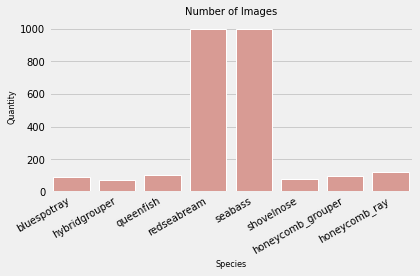

In [ ]:
# input code to plot bar charts

x = target_names
y = []
for x in target_names:
    y.append(len(os.listdir(os.path.join(unprocessed_path, x))))


plt.title("Number of Images", fontsize=10)
sns.set(rc={"figure.figsize": (8, 10)})
sns.barplot(x=target_names, y=y, color="salmon", saturation=0.5)
plt.xlabel("Species", fontsize=8)
plt.ylabel("Quantity", fontsize=8)
plt.xticks(fontsize=10, rotation=30, ha="right")
plt.yticks(fontsize=10)
plt.tight_layout()

<a id='link2'></a>


# Image Pre-Processing

Ensure the images are all of size 224 x 224. Padding was also added during resizing, to maintain the aspect ratio of the images. 

All resized images are saved into the 8 sub-folders of classes, inside the root folder.

A dataframe for all image data was also created.

## Image Resizing

In [ ]:
# clear directories
for x in target_names:
    clear_dir(x, "root/")

# check number of images inside folder after cleaning
for x in target_names:
    print(
        f"Number of images in {x}: {len(os.listdir(os.path.join(base_path, 'root/', x)))}"
    )

Number of images in bluespotray: 0
Number of images in hybridgrouper: 0
Number of images in queenfish: 0
Number of images in redseabream: 0
Number of images in seabass: 0
Number of images in shovelnose: 0
Number of images in honeycomb_grouper: 0
Number of images in honeycomb_ray: 0


In [ ]:
# write a function for image resizing
def resize(species):

    for filename in os.listdir(os.path.join(base_path, "rawimage/", species)):
        im = Image.open(os.path.join(base_path, "rawimage/", species, filename))

        desired_size = 224

        old_size = im.size
        ratio = float(desired_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])

        im = im.resize(new_size, Image.ANTIALIAS)

        new_im = Image.new("RGB", (desired_size, desired_size))
        new_im.paste(
            im, ((desired_size - new_size[0]) // 2, (desired_size - new_size[1]) // 2)
        )

        # save into a folder
        path = os.path.join(base_path, "root/", species)
        new_im.save(os.path.join(path, filename))


# call function for resizing
for x in target_names:
    resize(x)

# randomly check for size of image
im = Image.open("/content/drive/MyDrive/capstone/datasets/root/queenfish/talang_3.jpeg")
im.size

(224, 224)

## Create Dataframe (For Root Folder)

In [ ]:
rootpaths = glob(os.path.join(base_path, "root/", "*", "*"))

In [ ]:
root_df = create_df(rootpaths, "root_df")
root_df.head()

imagepath  ... category
0  /content/drive/MyDrive/capstone/datasets/root/...  ...        0
1  /content/drive/MyDrive/capstone/datasets/root/...  ...        0
2  /content/drive/MyDrive/capstone/datasets/root/...  ...        0
3  /content/drive/MyDrive/capstone/datasets/root/...  ...        0
4  /content/drive/MyDrive/capstone/datasets/root/...  ...        0

[5 rows x 4 columns]

<a id='link3'></a>


# Visualization of Images

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + "root/", image_size=(224, 224), batch_size=32, seed=42
)

Found 2560 files belonging to 8 classes.


In [ ]:
# create dictionary for classes

target_dict = {k: v for v, k in enumerate(dataset.class_names)}
target_dict

{'bluespotray': 0,
 'honeycomb_grouper': 1,
 'honeycomb_ray': 2,
 'hybridgrouper': 3,
 'queenfish': 4,
 'redseabream': 5,
 'seabass': 6,
 'shovelnose': 7}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


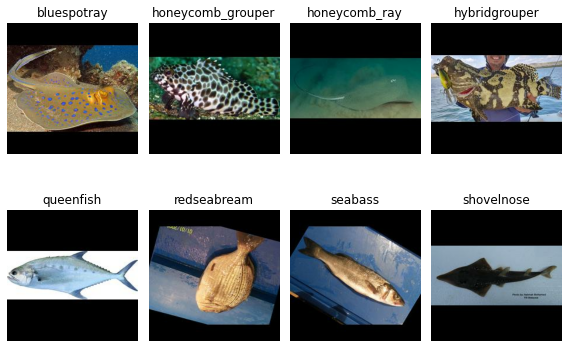

In [ ]:
# visualize the data with 8 classes

class_names = dataset.class_names

plt.figure(figsize=(8, 6))

for i in range(len(target_names)):
    filter = dataset.filter(lambda x, l: tf.math.equal(l[0], i))
    for images, labels in filter.take(2):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(class_names[labels.numpy()[0]])
        plt.axis("off")

    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.3)

plt.tight_layout()

<a id='link4'></a>

# Model Preparation

## Split Images into Train, Test, Validation Folders

After ensuring folders are clear from any previous runs, 70% of the images were copied into the 'train' folder, and the remaining 30% into the 'test' folder.

20% of the images from 'train' will be used for validation. This split is done in the pipeline section of this notebook.

In [ ]:
# clear directories if necessary

# for x in target_names:
#   clear_dir(x, 'train/')
#   clear_dir(x, 'test/')

# for x in target_names:
#   print(f"Train images in {x}: {len(os.listdir(os.path.join(base_path, 'train/', x)))}")
#   print(f"Test images in {x}: {len(os.listdir(os.path.join(base_path, 'test/', x)))}")
#   print()
#   print('------------------')

Train images in bluespotray: 0
Test images in bluespotray: 0
Val images in bluespotray: 0

------------------
Train images in hybridgrouper: 0
Test images in hybridgrouper: 0
Val images in hybridgrouper: 0

------------------
Train images in queenfish: 0
Test images in queenfish: 0
Val images in queenfish: 0

------------------
Train images in redseabream: 0
Test images in redseabream: 0
Val images in redseabream: 0

------------------
Train images in seabass: 0
Test images in seabass: 0
Val images in seabass: 0

------------------
Train images in shovelnose: 0
Test images in shovelnose: 0
Val images in shovelnose: 0

------------------
Train images in honeycomb_grouper: 0
Test images in honeycomb_grouper: 0
Val images in honeycomb_grouper: 0

------------------
Train images in honeycomb_ray: 0
Test images in honeycomb_ray: 0
Val images in honeycomb_ray: 0

------------------


In [ ]:
# decide split percentages
train_split = 0.7  # take 0.2 from here for validation
test_split = 0.3

# make directories to split root file images
for cls in target_names:
    src = base_path + "root/" + cls  # copy images from here
    allfiles = os.listdir(src)
    np.random.shuffle(allfiles)
    train_files, test_files = np.split(
        np.array(allfiles), [int(len(allfiles) * train_split)]
    )

    train_files = [src + "/" + name for name in train_files.tolist()]

    test_files = [src + "/" + name for name in test_files.tolist()]

    print("Images for ", cls)
    print("Total images: ", len(allfiles))
    print("Training: ", len(train_files))
    print("Testing: ", len(test_files))
    print()

    # and paste images here
    for name in train_files:
        shutil.copy(name, (base_path + "train/" + cls))

    for name in test_files:
        shutil.copy(name, (base_path + "test/" + cls))

Images for  bluespotray
Total images:  90
Training:  62
Testing:  28

Images for  hybridgrouper
Total images:  74
Training:  51
Testing:  23

Images for  queenfish
Total images:  105
Training:  73
Testing:  32

Images for  redseabream
Total images:  1000
Training:  700
Testing:  300

Images for  seabass
Total images:  1000
Training:  700
Testing:  300

Images for  shovelnose
Total images:  78
Training:  54
Testing:  24

Images for  honeycomb_grouper
Total images:  94
Training:  65
Testing:  29

Images for  honeycomb_ray
Total images:  119
Training:  83
Testing:  36



## Prepare Datasets for Pipeline

From the folders created above, the images were imported into train, validation and test datasets. 

A dataframe of the information for each dataset is used to facilitate the creation of input tensor slices into the pre-trained models. 

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + "train/",
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    seed=42,
    validation_split=0.2,
    subset="training",
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + "train/",
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path + "test/",
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    color_mode="rgb",
    seed=42,
    shuffle=False,
)


val_df = create_df(val_ds.file_paths, "val_df")
train_df = create_df(train_ds.file_paths, "train_df")
test_df = create_df(test_ds.file_paths, "test_df")

Found 1788 files belonging to 8 classes.
Using 1431 files for training.
Found 1788 files belonging to 8 classes.
Using 357 files for validation.
Found 772 files belonging to 8 classes.


In [14]:
# prepare input for tensor slices
train_files = tf.constant(train_ds.file_paths)
train_class = tf.constant(train_df["category"].astype("int32").tolist())
val_files = tf.constant(val_ds.file_paths)
val_class = tf.constant(val_df["category"].astype("int32").tolist())
test_files = tf.constant(test_ds.file_paths)
test_class = tf.constant(test_df["category"].astype("int32").tolist())

## Image Augmentation

The 2 main reasons for image augmentation are: 
1. Creating more images for training 
2. To prevent overfitting of the model

In [15]:
# augmentation parameters for dataset

augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2, fill_mode="constant"),
        layers.RandomZoom(0.1, fill_mode="nearest"),
        layers.RandomTranslation(0.1, 0.1, fill_mode="constant"),
    ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


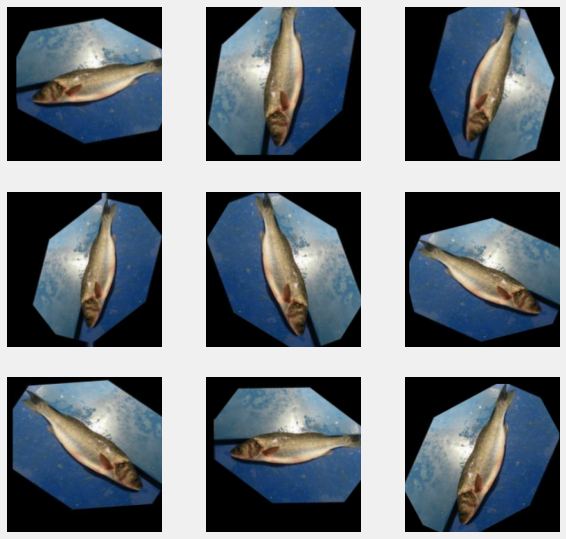

In [16]:
# check if augmented images are representative of 'real life'
# i.e. there should not be upside down fish

plt.figure(figsize=(9, 9))

for images, _ in train_ds.take(9):
    for i in range(0, 9):
        augmented_image = augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")

<a id='link5'></a>


[Home](#link0)   |   [Functions](#link00)

# Modelling 

4 different models were run in total:  
- Baseline CNN (without transfer learning)
- ResNet50V2
- VGG16
- EfficientNetB0

During the feature extraction phase, each pre-trained model was regularized using early stopping and dropout in the last 2 layers. 

Keeping all batch normalization layers frozen *so as not to undo the weights previously learnt,* the models were then fine tuned with the last 2 layers unfrozen. (Batch normalization layers contain 2 non-trainable weights. These track the mean and variance of the inputs.) 

In [174]:
print("Summary of Model Scores")
model_scores = [
    {
        "Model": "Baseline CNN",
        "Accuracy": 0.308,
        "Precision": 0.12,
        "Recall": 0.11,
        "F1-Score": 0.11,
    },
    {
        "Model": "ResNet50V2",
        "Accuracy": 0.991,
        "Precision": 0.97,
        "Recall": 0.97,
        "F1-Score": 0.97,
    },
    {
        "Model": "ResNet50V2 (Fine-Tuned)",
        "Accuracy": 0.995,
        "Precision": 0.98,
        "Recall": 0.98,
        "F1-Score": 0.98,
    },
    {
        "Model": "VGG16",
        "Accuracy": 0.990,
        "Precision": 0.967,
        "Recall": 0.96,
        "F1-Score": 0.97,
    },
    {
        "Model": "VGG16 (Fine-Tuned)",
        "Accuracy": 0.996,
        "Precision": 0.99,
        "Recall": 0.99,
        "F1-Score": 0.99,
    },
    {
        "Model": "EfficientNet",
        "Accuracy": 0.999,
        "Precision": 1.00,
        "Recall": 1.00,
        "F1-Score": 1.00,
    },
    {
        "Model": "EfficientNet (Fine-Tuned)",
        "Accuracy": 0.997,
        "Precision": 1.00,
        "Recall": 0.99,
        "F1-Score": 0.99,
    },
    {
        "Model": "Ensemble NN",
        "Accuracy": 0.996,
        "Precision": 0.99,
        "Recall": 0.99,
        "F1-Score": 0.99,
    },
]

pd.DataFrame(model_scores)

Summary of Model Scores


Model  Accuracy  Precision  Recall  F1-Score
0               Baseline CNN     0.308      0.120    0.11      0.11
1                 ResNet50V2     0.991      0.970    0.97      0.97
2    ResNet50V2 (Fine-Tuned)     0.995      0.980    0.98      0.98
3                      VGG16     0.990      0.967    0.96      0.97
4         VGG16 (Fine-Tuned)     0.996      0.990    0.99      0.99
5               EfficientNet     0.999      1.000    1.00      1.00
6  EfficientNet (Fine-Tuned)     0.997      1.000    0.99      0.99
7                Ensemble NN     0.996      0.990    0.99      0.99

<a id='link5a'></a>


##  Vanilla CNN (Baseline)

A sequential model with 2 convolutions was built as a baseline model. 

Images were rescaled so that pixels are between 0 and 1. 

The results of the model shows drastic overfitting, and the model doesn't seem to converge. When predicting on test images, the results were expected - the model does not perform well with only 31% accuracy. 

We did not further tune this model, as it serves only as a baseline. 

In [18]:
# model input

rescale = Sequential([layers.Rescaling(scale=1.0 / 255)])

train_cnn = tf.data.Dataset.from_tensor_slices((train_files, train_class))
train_cnn = (
    train_cnn.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (augmentation(x), y), num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

val_cnn = tf.data.Dataset.from_tensor_slices((val_files, val_class))
val_cnn = (
    val_cnn.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

test_cnn = tf.data.Dataset.from_tensor_slices((test_files, test_class))
test_cnn = (
    test_cnn.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

In [19]:
# fit and run model

benchmark = Sequential(
    [
        layers.Conv2D(256, 3, activation="relu", input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2)),
        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D((2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(8, activation="softmax"),
    ]
)

benchmark.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


history_cnn = benchmark.fit(
    train_cnn,
    epochs=50,
    validation_data=val_cnn,
    callbacks=[es(patience=5, min_delta=1e-3)],
)

Epoch 1/50
45/45 [==============================] - 258s 3s/step - loss: 1.6818 - accuracy: 0.3913 - val_loss: 1.1650 - val_accuracy: 0.4650
Epoch 2/50
45/45 [==============================] - 19s 220ms/step - loss: 1.1503 - accuracy: 0.5248 - val_loss: 0.9740 - val_accuracy: 0.5966
Epoch 3/50
45/45 [==============================] - 19s 221ms/step - loss: 1.0190 - accuracy: 0.5549 - val_loss: 0.8037 - val_accuracy: 0.6779
Epoch 4/50
45/45 [==============================] - 19s 221ms/step - loss: 0.9419 - accuracy: 0.6177 - val_loss: 0.7707 - val_accuracy: 0.6611
Epoch 5/50
45/45 [==============================] - 19s 220ms/step - loss: 0.9529 - accuracy: 0.6198 - val_loss: 0.8721 - val_accuracy: 0.5938
Epoch 6/50
45/45 [==============================] - 19s 220ms/step - loss: 0.9356 - accuracy: 0.6115 - val_loss: 0.7011 - val_accuracy: 0.7143
Epoch 7/50
45/45 [==============================] - 19s 221ms/step - loss: 0.8738 - accuracy: 0.6499 - val_loss: 0.8570 - val_accuracy: 0.5798
E

In [ ]:
plot_model_eval(history_cnn, "CNN Baseline")

### Predictions on test data

                   precision    recall  f1-score   support

      bluespotray       0.09      0.04      0.05        28
    hybridgrouper       0.02      0.03      0.02        29
        queenfish       0.00      0.00      0.00        36
      redseabream       0.00      0.00      0.00        23
          seabass       0.05      0.03      0.04        32
       shovelnose       0.39      0.39      0.39       300
honeycomb_grouper       0.40      0.40      0.40       300
    honeycomb_ray       0.00      0.00      0.00        24

         accuracy                           0.31       772
        macro avg       0.12      0.11      0.11       772
     weighted avg       0.31      0.31      0.31       772

The test accuracy score is:  0.3082901554404145


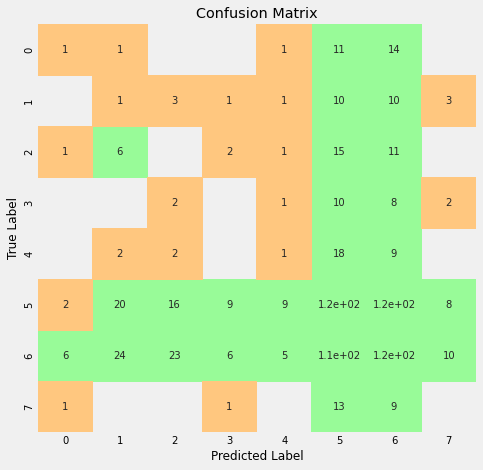

In [21]:
pred_baseline = np.argmax(benchmark.predict(test_cnn), axis=1)

plot_cm(test_df["category"], pred_baseline)

print(
    "The test accuracy score is: ", accuracy_score(test_df["category"], pred_baseline)
)

[Home](#link0)   |   [Functions](#link00)

<a id='link5b'></a>



## Transfer Learning - ResNet50V2

Freezing all model weights, a feature extraction with a ResNet50V2 was performed. 

Images were normalized to between -1 and 1, with input shape of 224. This was done in in-built preprocessing function. 

The results of the model are promising, with accuracies close to 100%. Both loss and accuracy converge. Loss represents how confident we are about making predictions (the smaller, the more confident). Our loss converges after about 15 epochs.

When predicting on test images, accuracy was at 99.1%, with 7 images being misclassified. 

After which, we unfroze the last 2 layers of the model for fine-tuning.



In [22]:
# model input
train_resnet = tf.data.Dataset.from_tensor_slices((train_files, train_class))
train_resnet = (
    train_resnet.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (augmentation(x), y), num_parallel_calls=AUTOTUNE)
    .map(
        lambda x, y: (keras.applications.resnet_v2.preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE,
    )
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

val_resnet = tf.data.Dataset.from_tensor_slices((val_files, val_class))
val_resnet = (
    val_resnet.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(
        lambda x, y: (keras.applications.resnet_v2.preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE,
    )
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

test_resnet = tf.data.Dataset.from_tensor_slices((test_files, test_class))
test_resnet = (
    test_resnet.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(
        lambda x, y: (keras.applications.resnet_v2.preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE,
    )
    .batch(32)
)

# tensor shape
input_tensor = Input(shape=(224, 224, 3))

In [23]:
# fit and run model
base_resnet = ResNet50V2(
    weights="imagenet", include_top=False, input_tensor=input_tensor
)


# freeze all layers of resnet (i.e. feature extraction)
# model weights will not be updated
base_resnet.trainable = False

resnet_model = Sequential(
    [
        base_resnet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="softmax"),
    ]
)

resnet_model.summary()

94683136/94668760 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               

In [24]:
Adam = keras.optimizers.Adam(learning_rate=1e-4)

resnet_model.compile(
    loss="categorical_crossentropy", optimizer=Adam, metrics=["accuracy"]
)

In [25]:
history_resnet_es = resnet_model.fit(
    train_resnet,
    validation_data=val_resnet,
    epochs=50,
    callbacks=[es(patience=5, min_delta=1e-3), checkpoint("resnet_es")],
)

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.9456 - accuracy: 0.6883
Epoch 1: val_loss improved from inf to 0.31064, saving model to /content/drive/MyDrive/capstone/model/resnet_es_checkpoint.hdf5
45/45 [==============================] - 23s 243ms/step - loss: 0.9456 - accuracy: 0.6883 - val_loss: 0.3106 - val_accuracy: 0.9132
Epoch 2/50
44/45 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8956
Epoch 2: val_loss improved from 0.31064 to 0.12567, saving model to /content/drive/MyDrive/capstone/model/resnet_es_checkpoint.hdf5
45/45 [==============================] - 18s 203ms/step - loss: 0.3165 - accuracy: 0.8973 - val_loss: 0.1257 - val_accuracy: 0.9804
Epoch 3/50
44/45 [============================>.] - ETA: 0s - loss: 0.1756 - accuracy: 0.9510
Epoch 3: val_loss improved from 0.12567 to 0.07627, saving model to /content/drive/MyDrive/capstone/model/resnet_es_checkpoint.hdf5
45/45 [==============================] - 21s 256ms/step - loss

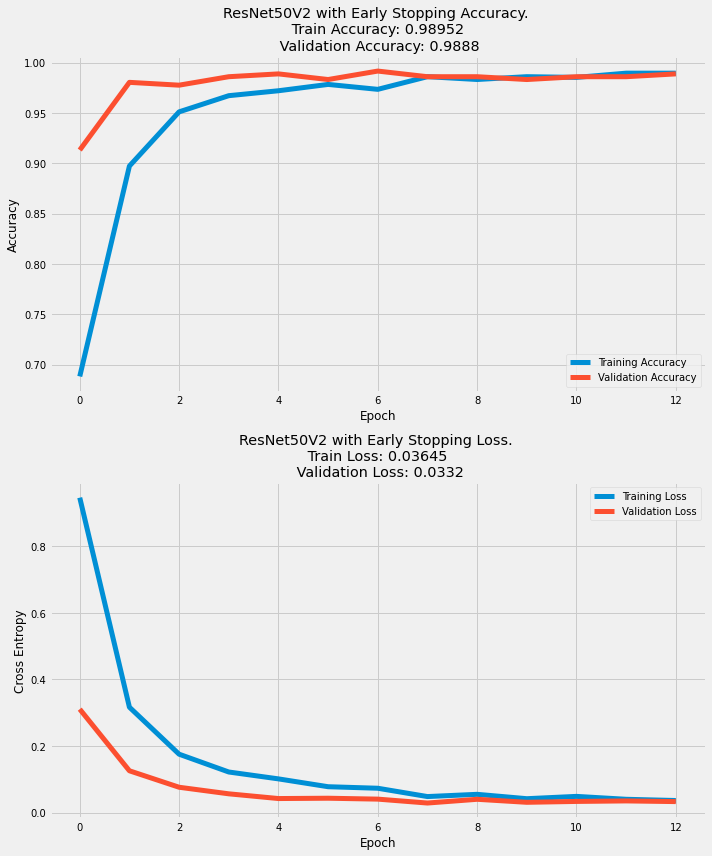

In [26]:
plot_model_eval(history_resnet_es, "ResNet50V2 with Early Stopping")

### Predictions on Test Data

                   precision    recall  f1-score   support

      bluespotray       0.96      0.96      0.96        28
    hybridgrouper       0.94      1.00      0.97        29
        queenfish       0.97      0.97      0.97        36
      redseabream       1.00      0.91      0.95        23
          seabass       1.00      0.91      0.95        32
       shovelnose       1.00      1.00      1.00       300
honeycomb_grouper       1.00      1.00      1.00       300
    honeycomb_ray       0.89      1.00      0.94        24

         accuracy                           0.99       772
        macro avg       0.97      0.97      0.97       772
     weighted avg       0.99      0.99      0.99       772

The test accuracy score is:  0.9909326424870466


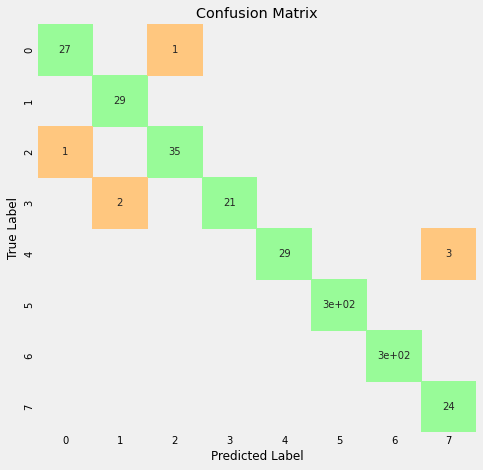

In [27]:
pred_class_res = np.argmax(resnet_model.predict(test_resnet), axis=1)

plot_cm(test_df["category"], pred_class_res)

print(
    "The test accuracy score is: ", accuracy_score(test_df["category"], pred_class_res)
)

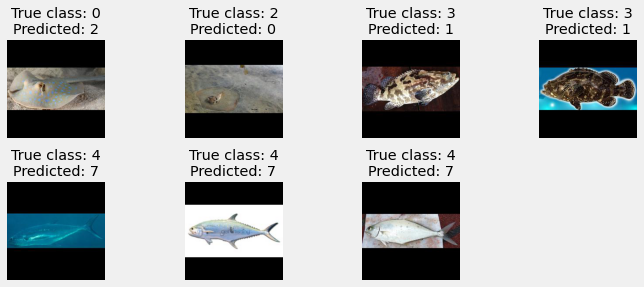

In [28]:
plot_wrong_img(pred_class_res)

### Fine Tune - Unfreeze Top Layers 

We unfroze the top 2 layers and fine-tuned the model on features unique to the fish images. 

We first ran models with a very low learning rate (at 1e-8 and 1e-6), as we wanted to facilitate learning. However, the models did not converge or were underfitted. 

Hence, a learning rate of 1e-4 was used, and early stopping parameters were tuned to facilitate more learning. The model was improving, but still not converging. The last round of tuning was done to adjust the epsilon value of the Adam optimizer. The default of 1e-8 was too low, and was increased to 1e-3 instead.

In summary: 
- too small a learning rate -> bad generalization to data introduced
- too large a learning rate -> oscillations in loss and accuracy
- smaller epsilon -> larger variances between learning rates (i.e. unstable)
- larger epsilon -> more bias introduced into model

Accuracy on test predictions increased to 99.5%. 

In [29]:
# load model weights
reload_resnet_es = load_model(
    "/content/drive/MyDrive/capstone/model/resnet_es_checkpoint.hdf5"
)

In [30]:
# double check trainable layers

reload_resnet_es.summary()
print()
print("Trainable weights:{}".format(len(reload_resnet_es.trainable_weights)))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                      

In [31]:
reload_resnet_es.layers[0].summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [32]:
# unfreeze the last layers
to_unfreeze = ["conv5", "post_"]
set_trainable = False
for layer in reload_resnet_es.layers[0].layers:
    if any(x in layer.name for x in to_unfreeze):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        tf.keras.layers.BatchNormalization(
            trainable=False
        )  # do not update weights of batch normalization layers
    else:
        layer.trainable = False

In [33]:
# check what has been unfrozen
print("Trainable weights:{}".format(len(reload_resnet_es.trainable_weights)))
print()

reload_resnet_es.layers[0].summary()

Trainable weights:42

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                   

#### At learning rate of 1e-4 and epsilon 1e-3

In [34]:
# fit and run model

Adam = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-3)

reload_resnet_es.compile(
    loss="categorical_crossentropy", optimizer=Adam, metrics=["accuracy"]
)

history_reload_resnet = reload_resnet_es.fit(
    train_resnet,
    validation_data=val_resnet,
    epochs=50,
    callbacks=[es(patience=10, min_delta=1e-5), checkpoint("resnet_es_2_reload")],
)

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9616
Epoch 1: val_loss improved from inf to 0.05568, saving model to /content/drive/MyDrive/capstone/model/resnet_es_2_reload_checkpoint.hdf5
45/45 [==============================] - 25s 254ms/step - loss: 0.1827 - accuracy: 0.9616 - val_loss: 0.0557 - val_accuracy: 0.9776
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9825
Epoch 2: val_loss improved from 0.05568 to 0.03047, saving model to /content/drive/MyDrive/capstone/model/resnet_es_2_reload_checkpoint.hdf5
45/45 [==============================] - 20s 240ms/step - loss: 0.0599 - accuracy: 0.9825 - val_loss: 0.0305 - val_accuracy: 0.9916
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9909
Epoch 3: val_loss improved from 0.03047 to 0.02620, saving model to /content/drive/MyDrive/capstone/model/resnet_es_2_reload_checkpoint.hdf5
45/45 [============================

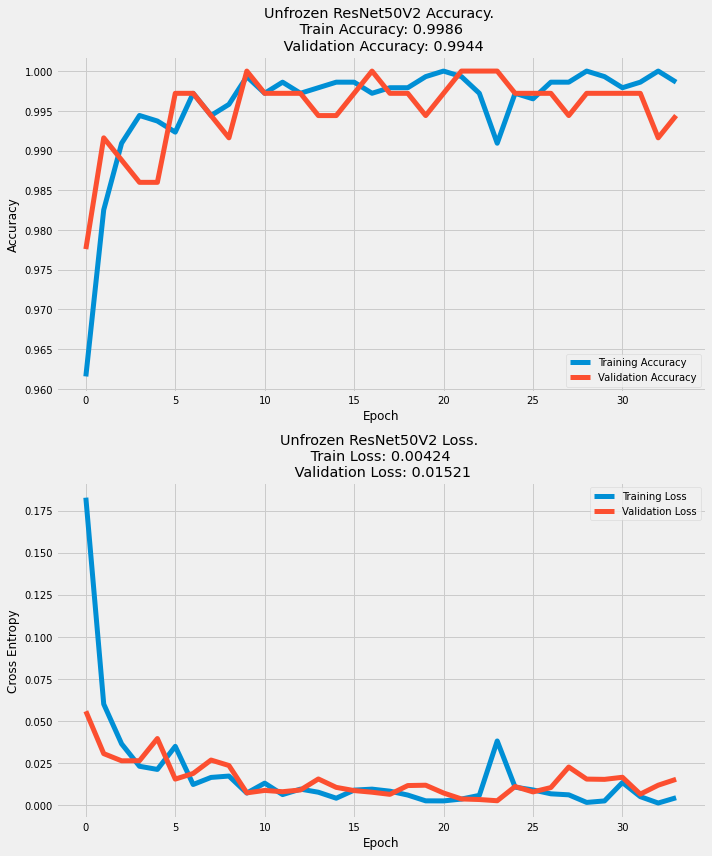

In [35]:
plot_model_eval(history_reload_resnet, "Unfrozen ResNet50V2")

                   precision    recall  f1-score   support

      bluespotray       0.96      0.96      0.96        28
    hybridgrouper       1.00      1.00      1.00        29
        queenfish       0.95      0.97      0.96        36
      redseabream       1.00      1.00      1.00        23
          seabass       0.97      0.97      0.97        32
       shovelnose       1.00      1.00      1.00       300
honeycomb_grouper       1.00      1.00      1.00       300
    honeycomb_ray       1.00      0.96      0.98        24

         accuracy                           0.99       772
        macro avg       0.98      0.98      0.98       772
     weighted avg       0.99      0.99      0.99       772

The test accuracy score is:  0.9948186528497409


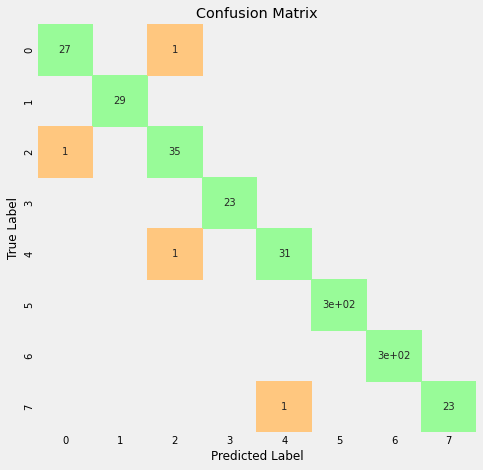

In [36]:
pred_class_res = np.argmax(reload_resnet_es.predict(test_resnet), axis=1)

plot_cm(test_df["category"], pred_class_res)

print(
    "The test accuracy score is: ", accuracy_score(test_df["category"], pred_class_res)
)

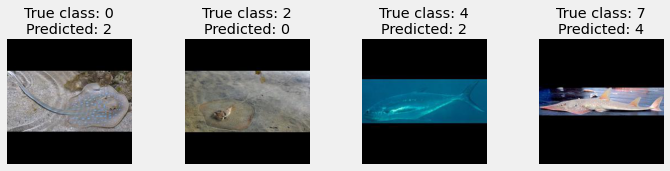

In [37]:
plot_wrong_img(pred_class_res)

[Home](#link0)   |   [Functions](#link00)

<a id='link5c'></a>



## Transfer Learning - VGG16

Similar to the first transfer learning model, all weights were frozen for feature extraction.

Images were converted from RGB to BGR, then centered around 0 with  input shape of 224. This was done in in-built preprocessing function.

For VGG16, we used RMSprop instead of Adam as an optimizer because tuning of both learning rate and epsilon did not seem to produce models that converged. Instead, we chose RMSProp, as it is the optimizer that scales the learning rate automatically and finds the most optimal path.

When predicting on test images, accuracy was at 99.0%, with 8 images being misclassified.

After which, we unfroze the last 2 layers of the model for fine-tuning.

In [41]:
# model input
train_vgg = tf.data.Dataset.from_tensor_slices((train_files, train_class))
train_vgg = (
    train_vgg.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (augmentation(x), y), num_parallel_calls=AUTOTUNE)
    .map(
        lambda x, y: (keras.applications.vgg16.preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE,
    )
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

val_vgg = tf.data.Dataset.from_tensor_slices((val_files, val_class))
val_vgg = (
    val_vgg.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(
        lambda x, y: (keras.applications.vgg16.preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE,
    )
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

# need to preprocess test dataset
test_vgg = tf.data.Dataset.from_tensor_slices((test_files, test_class))
test_vgg = (
    test_vgg.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(
        lambda x, y: (keras.applications.vgg16.preprocess_input(x), y),
        num_parallel_calls=AUTOTUNE,
    )
    .batch(32)
)

# tensor shape
input_tensor = Input(shape=(224, 224, 3))

In [42]:
# fit and run model

base_vgg = VGG16(weights="imagenet", include_top=False, input_tensor=input_tensor)


# freeze all layers of pre-trained model
base_vgg.trainable = False

# check if this could work
vgg_model = Sequential(
    [
        base_vgg,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="softmax"),
    ]
)

vgg_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               

In [43]:
RMSprop = keras.optimizers.RMSprop(learning_rate=1e-4)

vgg_model.compile(
    loss="categorical_crossentropy", optimizer=RMSprop, metrics=["accuracy"]
)

In [44]:
history_vgg_es = vgg_model.fit(
    train_vgg,
    validation_data=val_vgg,
    epochs=40,
    callbacks=[es(patience=5, min_delta=1e-4), checkpoint("vgg16_es")],
)

Epoch 1/40
45/45 [==============================] - ETA: 0s - loss: 1.1297 - accuracy: 0.6744
Epoch 1: val_loss improved from inf to 0.27181, saving model to /content/drive/MyDrive/capstone/model/vgg16_es_checkpoint.hdf5
45/45 [==============================] - 13s 194ms/step - loss: 1.1297 - accuracy: 0.6744 - val_loss: 0.2718 - val_accuracy: 0.9272
Epoch 2/40
45/45 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8917
Epoch 2: val_loss improved from 0.27181 to 0.14931, saving model to /content/drive/MyDrive/capstone/model/vgg16_es_checkpoint.hdf5
45/45 [==============================] - 9s 140ms/step - loss: 0.3460 - accuracy: 0.8917 - val_loss: 0.1493 - val_accuracy: 0.9636
Epoch 3/40
45/45 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9455
Epoch 3: val_loss improved from 0.14931 to 0.11371, saving model to /content/drive/MyDrive/capstone/model/vgg16_es_checkpoint.hdf5
45/45 [==============================] - 10s 151ms/step - loss: 0.

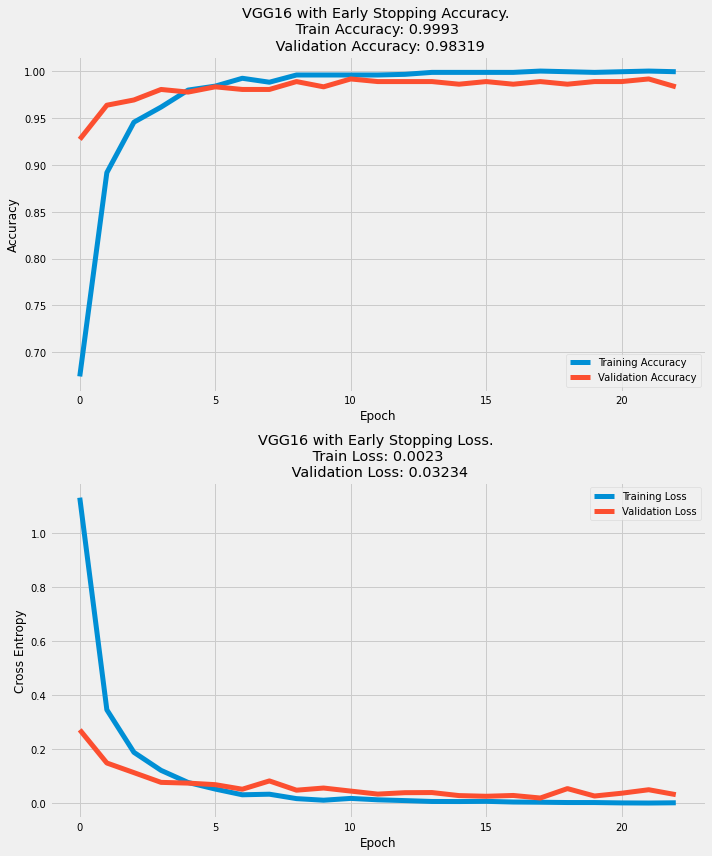

In [45]:
plot_model_eval(history_vgg_es, "VGG16 with Early Stopping")

### Predictions on Test Data

                   precision    recall  f1-score   support

      bluespotray       0.97      1.00      0.98        28
    hybridgrouper       0.91      1.00      0.95        29
        queenfish       0.94      0.94      0.94        36
      redseabream       1.00      0.87      0.93        23
          seabass       1.00      0.97      0.98        32
       shovelnose       1.00      1.00      1.00       300
honeycomb_grouper       1.00      1.00      1.00       300
    honeycomb_ray       0.96      0.92      0.94        24

         accuracy                           0.99       772
        macro avg       0.97      0.96      0.97       772
     weighted avg       0.99      0.99      0.99       772

The test accuracy score is:  0.9896373056994818


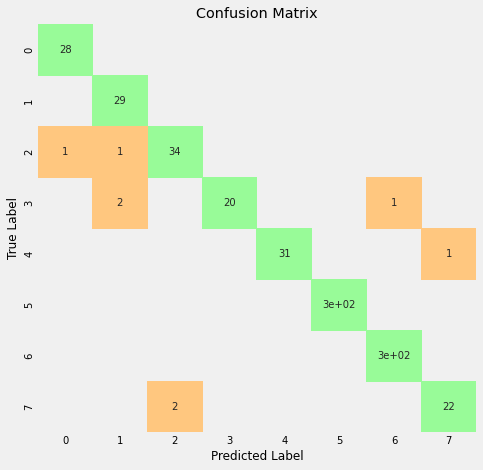

In [46]:
pred_class_vgg = np.argmax(vgg_model.predict(test_vgg), axis=1)

plot_cm(test_df["category"], pred_class_vgg)

print(
    "The test accuracy score is: ", accuracy_score(test_df["category"], pred_class_vgg)
)

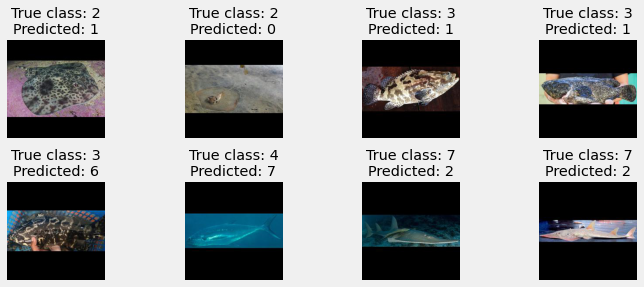

In [47]:
plot_wrong_img(pred_class_vgg)

### Fine Tune - Unfreeze Top Layers 

Similarly, we unfroze the top 2 layers for fine-tuning. 

Tuning this model to converge was harder than expected. Despite running the model with different learning rates on Adam and RMSProp, we found that an RMSProp of learning rate of 1e-4 seemed to produce the best model so far. 

Accuracy score was 99.6% on test images, with 3 images misclassified. This is an improvement from before it was fine tuned.

In [48]:
# load model weights
reload_vgg_es = load_model(
    "/content/drive/MyDrive/capstone/model/vgg16_es_checkpoint.hdf5"
)

In [49]:
# double check trainable layers

reload_vgg_es.summary()
print()
print("Trainable weights:{}".format(len(reload_vgg_es.trainable_weights)))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                      

In [50]:
reload_vgg_es.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [51]:
# unfreeze the last layers
to_unfreeze = ["block5"]
set_trainable = False
for layer in reload_vgg_es.layers[0].layers:
    if any(x in layer.name for x in to_unfreeze):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        tf.keras.layers.BatchNormalization(
            trainable=False
        )  # do not update weights of batch normalization layers
    else:
        layer.trainable = False

In [52]:
# check what has been unfrozen

print("Trainable weights:{}".format(len(reload_vgg_es.trainable_weights)))
print()

reload_vgg_es.layers[0].summary()

Trainable weights:14

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56,

#### At learning rate of 1e-4

In [53]:
# to re-initialize learning rate to be smaller
# change optimizer just because adam doesnt give good results
RMSprop = keras.optimizers.RMSprop(learning_rate=1e-4)

reload_vgg_es.compile(
    loss="categorical_crossentropy", optimizer=RMSprop, metrics=["accuracy"]
)

history_reload_vgg = reload_vgg_es.fit(
    train_vgg,
    validation_data=val_vgg,
    epochs=25,
    callbacks=[es(patience=8, min_delta=1e-5), checkpoint("vgg_es_2_reload")],
)

Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 0.8130 - accuracy: 0.8693
Epoch 1: val_loss improved from inf to 0.06915, saving model to /content/drive/MyDrive/capstone/model/vgg_es_2_reload_checkpoint.hdf5
45/45 [==============================] - 13s 194ms/step - loss: 0.8130 - accuracy: 0.8693 - val_loss: 0.0691 - val_accuracy: 0.9692
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9790
Epoch 2: val_loss improved from 0.06915 to 0.01819, saving model to /content/drive/MyDrive/capstone/model/vgg_es_2_reload_checkpoint.hdf5
45/45 [==============================] - 10s 162ms/step - loss: 0.0717 - accuracy: 0.9790 - val_loss: 0.0182 - val_accuracy: 0.9944
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9923
Epoch 3: val_loss did not improve from 0.01819
45/45 [==============================] - 9s 141ms/step - loss: 0.0362 - accuracy: 0.9923 - val_loss: 0.0422 - val_accuracy: 0.9860
Epoc

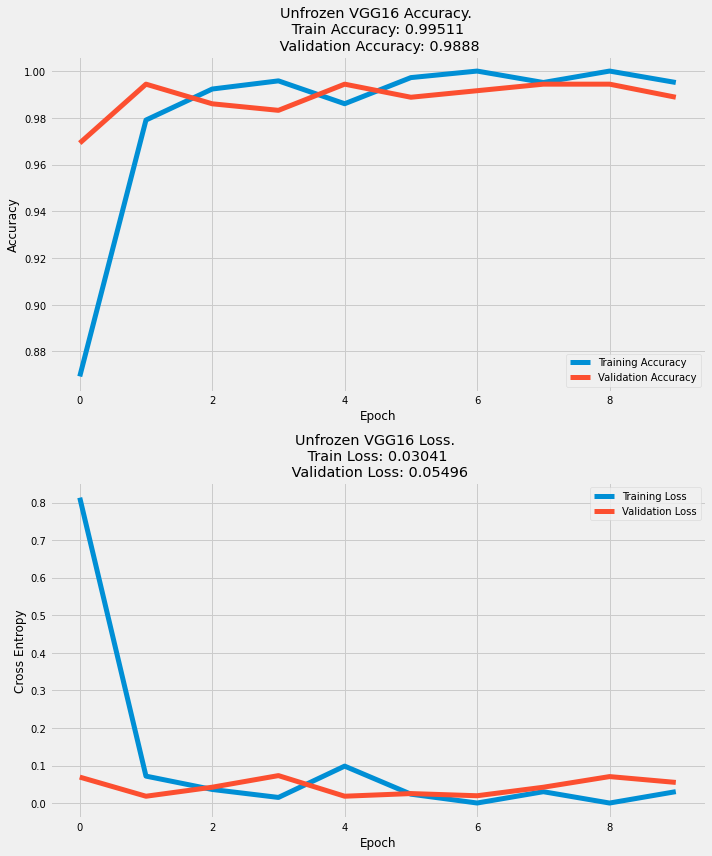

In [54]:
plot_model_eval(history_reload_vgg, "Unfrozen VGG16")

                   precision    recall  f1-score   support

      bluespotray       0.97      1.00      0.98        28
    hybridgrouper       0.97      1.00      0.98        29
        queenfish       1.00      0.94      0.97        36
      redseabream       1.00      1.00      1.00        23
          seabass       1.00      0.97      0.98        32
       shovelnose       1.00      1.00      1.00       300
honeycomb_grouper       1.00      1.00      1.00       300
    honeycomb_ray       0.96      1.00      0.98        24

         accuracy                           1.00       772
        macro avg       0.99      0.99      0.99       772
     weighted avg       1.00      1.00      1.00       772

The test accuracy score is:  0.9961139896373057


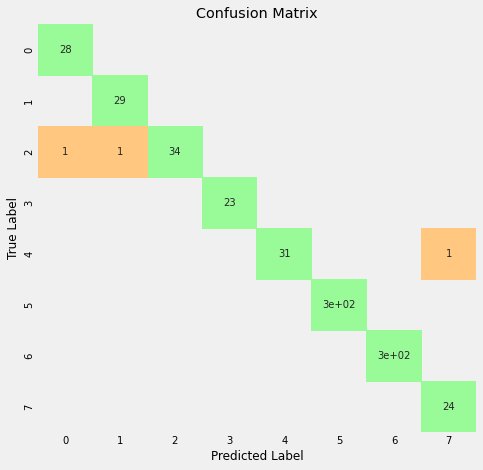

In [55]:
# predictions on classes
pred_class_vgg = np.argmax(reload_vgg_es.predict(test_vgg), axis=1)

plot_cm(test_df["category"], pred_class_vgg)

print(
    "The test accuracy score is: ", accuracy_score(test_df["category"], pred_class_vgg)
)

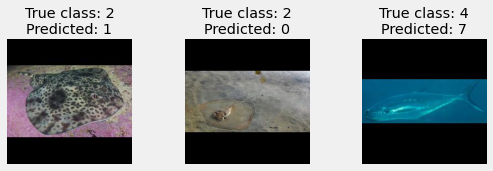

In [56]:
plot_wrong_img(pred_class_vgg)

[Home](#link0)   |   [Functions](#link00)

<a id='link5d'></a>


## Transfer Learning - EfficientNet

All weights were frozen for feature extraction. For the EfficientNet model, no normalization or scaling was required for images. Input shape remained at 224 x 224. 

Similar to the ResNet50 model, we used an Adam optimizer and tuned the learning rate and epsilon values until the model converged. 

The EfficientNet model performed the best overall, with test prediction accuracy at 99.9% accuracy and only 1 image being misclassified. 

After which, we unfroze the last 2 layers of the model for fine-tuning.

In [60]:
# model input
train_effnet = tf.data.Dataset.from_tensor_slices((train_files, train_class))
train_effnet = (
    train_effnet.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (augmentation(x), y), num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

val_effnet = tf.data.Dataset.from_tensor_slices((val_files, val_class))
val_effnet = (
    val_effnet.map(_parse_function, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(AUTOTUNE)
)

# need to preprocess test dataset
test_effnet = tf.data.Dataset.from_tensor_slices((test_files, test_class))
test_effnet = test_effnet.map(_parse_function, num_parallel_calls=AUTOTUNE).batch(32)

# tensor shape
input_tensor = Input(shape=(224, 224, 3))

In [61]:
# fit and run model

base_effnet = EfficientNetB0(
    weights="imagenet", include_top=False, input_tensor=input_tensor
)


# freeze all layers of efficientnet
base_effnet.trainable = False


# check if this could work
effnet_model = Sequential(
    [
        base_effnet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="softmax"),
    ]
)

effnet_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 512)               655872    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               

In [62]:
Adam = keras.optimizers.Adam(learning_rate=1e-4)

effnet_model.compile(
    loss="categorical_crossentropy", optimizer=Adam, metrics=["accuracy"]
)

In [63]:
history_effnet_es = effnet_model.fit(
    train_effnet,
    validation_data=val_effnet,
    epochs=25,
    callbacks=[es(patience=5, min_delta=1e-3), checkpoint("effnet_es")],
)

Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 0.9900 - accuracy: 0.7107
Epoch 1: val_loss improved from inf to 0.37704, saving model to /content/drive/MyDrive/capstone/model/effnet_es_checkpoint.hdf5
45/45 [==============================] - 14s 136ms/step - loss: 0.9900 - accuracy: 0.7107 - val_loss: 0.3770 - val_accuracy: 0.8627
Epoch 2/25
44/45 [============================>.] - ETA: 0s - loss: 0.3349 - accuracy: 0.9261
Epoch 2: val_loss improved from 0.37704 to 0.16939, saving model to /content/drive/MyDrive/capstone/model/effnet_es_checkpoint.hdf5
45/45 [==============================] - 6s 88ms/step - loss: 0.3328 - accuracy: 0.9266 - val_loss: 0.1694 - val_accuracy: 0.9720
Epoch 3/25
44/45 [============================>.] - ETA: 0s - loss: 0.1561 - accuracy: 0.9787
Epoch 3: val_loss improved from 0.16939 to 0.08137, saving model to /content/drive/MyDrive/capstone/model/effnet_es_checkpoint.hdf5
45/45 [==============================] - 6s 100ms/step - loss: 0

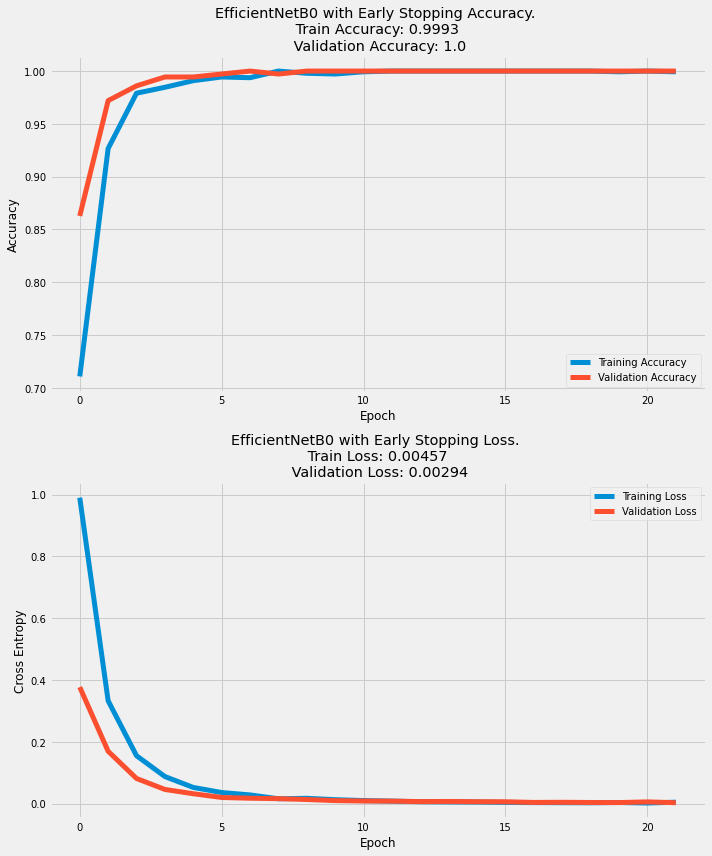

In [64]:
plot_model_eval(history_effnet_es, "EfficientNetB0 with Early Stopping")

### Predictions on Test Data

                   precision    recall  f1-score   support

      bluespotray       0.97      1.00      0.98        28
    hybridgrouper       1.00      1.00      1.00        29
        queenfish       1.00      0.97      0.99        36
      redseabream       1.00      1.00      1.00        23
          seabass       1.00      1.00      1.00        32
       shovelnose       1.00      1.00      1.00       300
honeycomb_grouper       1.00      1.00      1.00       300
    honeycomb_ray       1.00      1.00      1.00        24

         accuracy                           1.00       772
        macro avg       1.00      1.00      1.00       772
     weighted avg       1.00      1.00      1.00       772

The test accuracy score is:  0.9987046632124352


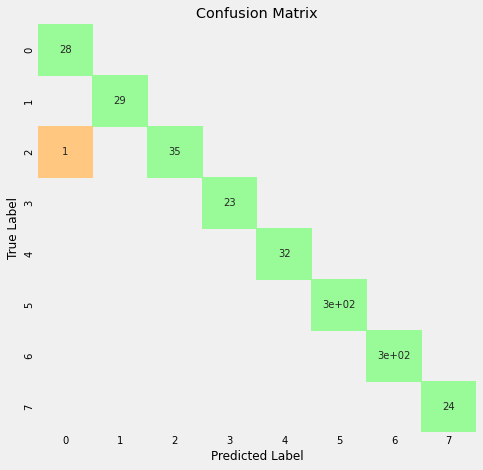

In [65]:
pred_class_eff = np.argmax(effnet_model.predict(test_effnet), axis=1)

plot_cm(test_df["category"], pred_class_eff)

print(
    "The test accuracy score is: ", accuracy_score(test_df["category"], pred_class_eff)
)

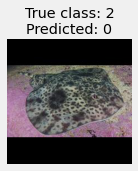

In [66]:
plot_wrong_img(pred_class_eff)

### Fine Tune - Unfreeze Top Layers 

Similarly, we unfroze the top 2 layers for fine-tuning.

Accuracy score was 99.7% on test images, with 2 images misclassified. 

Although accuracy score dropped after fine tuning, this model still outperformed the other 2 fine tuned models.

In [67]:
# load model weights
reload_effnet_es = load_model(
    "/content/drive/MyDrive/capstone/model/effnet_es_checkpoint.hdf5"
)

In [68]:
# double check trainable layers

reload_effnet_es.summary()
print()
print("Trainable weights:{}".format(len(reload_effnet_es.trainable_weights)))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 512)               655872    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                      

In [69]:
reload_effnet_es.layers[0].summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [70]:
# unfreeze the last layers
to_unfreeze = ["block7a", "top_"]
set_trainable = False
for layer in reload_effnet_es.layers[0].layers:
    if any(x in layer.name for x in to_unfreeze):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        tf.keras.layers.BatchNormalization(
            trainable=False
        )  # do not update weights of batch normalization layers
    else:
        layer.trainable = False

In [71]:
# check what has been unfrozen

print("Trainable weights:{}".format(len(reload_effnet_es.trainable_weights)))
print()

reload_effnet_es.layers[0].summary()

Trainable weights:24

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0         

#### At learning rate of 1e-4 and epsilon 1e-7

In [72]:
Adam = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-7)

reload_effnet_es.compile(
    loss="categorical_crossentropy", optimizer=Adam, metrics=["accuracy"]
)

history_reload_effnet_es = reload_effnet_es.fit(
    train_effnet,
    validation_data=val_effnet,
    epochs=50,
    callbacks=[es(patience=10, min_delta=1e-6), checkpoint("effnet_es_2_reload")],
)

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9902
Epoch 1: val_loss improved from inf to 0.01052, saving model to /content/drive/MyDrive/capstone/model/effnet_es_2_reload_checkpoint.hdf5
45/45 [==============================] - 15s 137ms/step - loss: 0.0754 - accuracy: 0.9902 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 2/50
44/45 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9979
Epoch 2: val_loss improved from 0.01052 to 0.00267, saving model to /content/drive/MyDrive/capstone/model/effnet_es_2_reload_checkpoint.hdf5
45/45 [==============================] - 6s 92ms/step - loss: 0.0103 - accuracy: 0.9979 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9993
Epoch 3: val_loss did not improve from 0.00267
45/45 [==============================] - 5s 79ms/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 0.0031 - val_accuracy: 1.0000
E

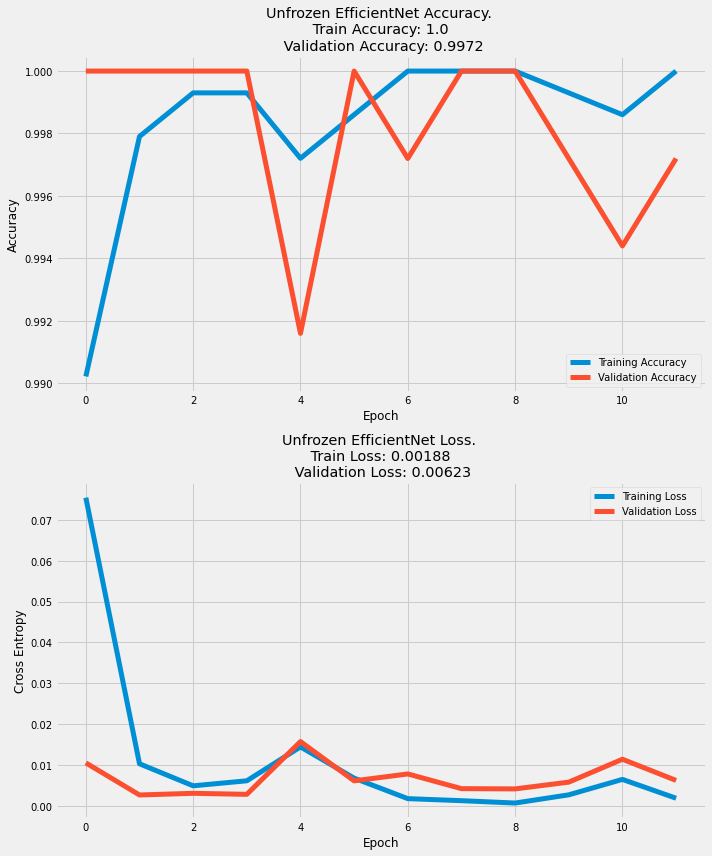

In [73]:
plot_model_eval(history_reload_effnet_es, "Unfrozen EfficientNet")

                   precision    recall  f1-score   support

      bluespotray       0.97      1.00      0.98        28
    hybridgrouper       1.00      1.00      1.00        29
        queenfish       1.00      0.97      0.99        36
      redseabream       1.00      1.00      1.00        23
          seabass       1.00      1.00      1.00        32
       shovelnose       1.00      1.00      1.00       300
honeycomb_grouper       1.00      1.00      1.00       300
    honeycomb_ray       1.00      0.96      0.98        24

         accuracy                           1.00       772
        macro avg       1.00      0.99      0.99       772
     weighted avg       1.00      1.00      1.00       772

The test accuracy score is:  0.9974093264248705


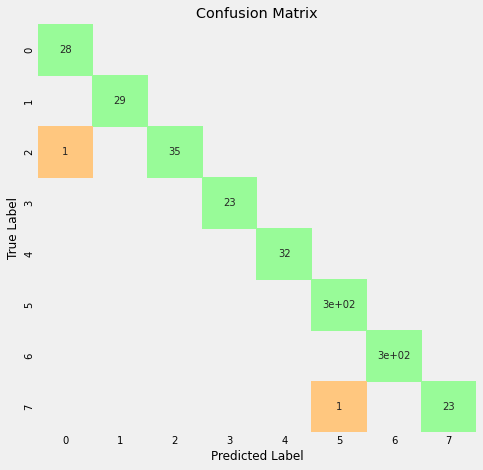

In [74]:
# try on test preds again

pred_class_effnet = np.argmax(reload_effnet_es.predict(test_effnet), axis=1)
plot_cm(test_df["category"], pred_class_effnet)
print(
    "The test accuracy score is: ",
    accuracy_score(test_df["category"], pred_class_effnet),
)

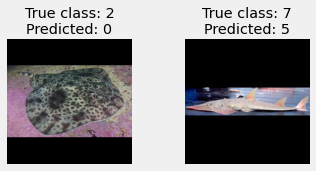

In [75]:
plot_wrong_img(pred_class_effnet)

<a id='link5e'></a>


[Home](#link0)   |   [Functions](#link00)

# Ensemble NN

The last model we tried was an ensemble of all the 3 fine-tuned pre-trained models we have previously run.

The strategy was to do a soft voting of equal weights between the 3 models. We added up the confidence scores of each image prediction before passing it into the argmax function to return the class names. 

However, this did not improve our results. Accuracy dropped by 0.1% from our best fine tuned pre-trained model (EfficientNetB0 - 99.7%) to 99.6% in the ensemble model. 

We postulate that it is due to the misclassification of certain types of images that were common throughout the 3 pre-trained models. This will be explored in the later section. 

In [181]:
# load all models
model1 = load_model(
    os.path.join(
        "/content/drive/MyDrive/capstone/model/", "vgg_es_2_reload_checkpoint.hdf5"
    )
)
model2 = load_model(
    os.path.join(
        "/content/drive/MyDrive/capstone/model/", "effnet_es_2_reload_checkpoint.hdf5"
    )
)
model3 = load_model(
    os.path.join(
        "/content/drive/MyDrive/capstone/model/", "resnet_es_2_reload_checkpoint.hdf5"
    )
)

# get confidence for each model's class prediction
pred1 = model1.predict(test_vgg)
pred2 = model2.predict(test_effnet)
pred3 = model3.predict(test_resnet)

# get output of class prediction based on highest confidence score
final_pred = np.array([])
for i in range(0, len(test_df.index)):
    sum_confidence = pred1[i] + pred2[i] + pred3[i]
    final_pred = np.append(final_pred, int(np.argmax(sum_confidence)))

                   precision    recall  f1-score   support

      bluespotray       0.97      1.00      0.98        28
    hybridgrouper       0.97      1.00      0.98        29
        queenfish       0.97      0.94      0.96        36
      redseabream       1.00      1.00      1.00        23
          seabass       1.00      0.97      0.98        32
       shovelnose       1.00      1.00      1.00       300
honeycomb_grouper       1.00      1.00      1.00       300
    honeycomb_ray       1.00      1.00      1.00        24

         accuracy                           1.00       772
        macro avg       0.99      0.99      0.99       772
     weighted avg       1.00      1.00      1.00       772

The test accuracy score is:  0.9961139896373057


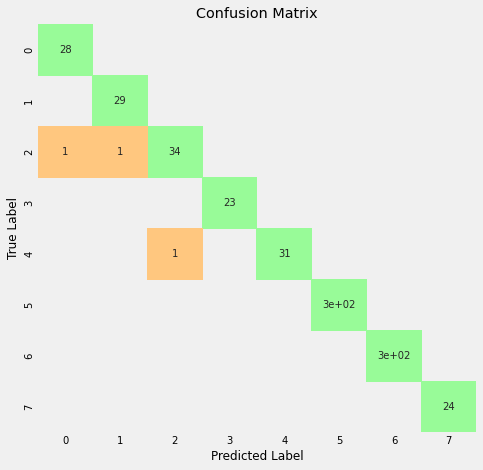

In [182]:
plot_cm(test_df["category"], final_pred)
print("The test accuracy score is: ", accuracy_score(test_df["category"], final_pred))

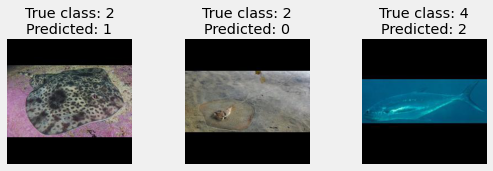

In [81]:
plot_wrong_img(final_pred)

<a id='link6'></a>


[Home](#link0)   |   [Functions](#link00)

# Visualizing what happens in the *black box* 
(A VGG16 Example)

In [224]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


# image array to be used for visualization
img_array = get_img_array(
    os.path.join(base_path, "root/", "honeycomb_grouper", "honeycomb_30.jpeg"),
    target_size=(224, 224),
)

(-0.5, 223.5, 223.5, -0.5)

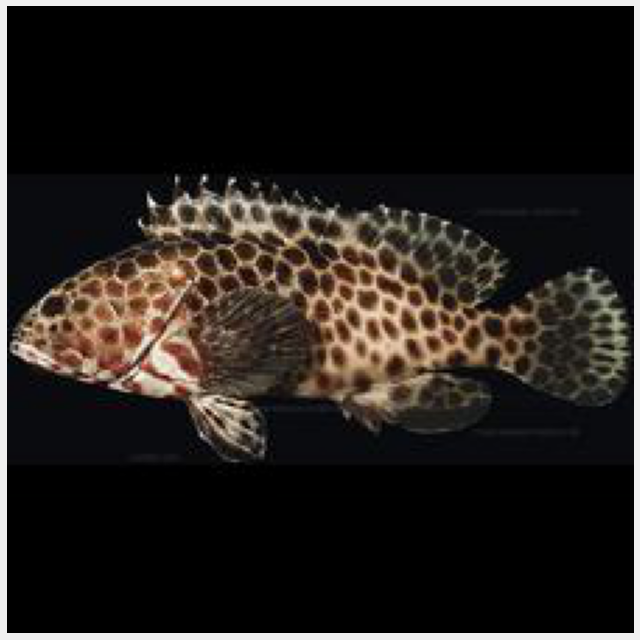

In [261]:
# what the original image looks like
plt.imshow(
    keras.utils.load_img(
        os.path.join(base_path, "root/", "honeycomb_grouper", "honeycomb_30.jpeg")
    )
)
plt.axis("off")

In [226]:
# load the model and view all layers
base_model = VGG16(weights="imagenet")
activation_model = Model(inputs=base_model.inputs, outputs=base_model.layers[1].output)

In [227]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Plot Filters

As part of (personal) learning, we visualize the filters / kernels that pass over an image. 

For the first convolutional layer, there are 64 filters. We are only plotting 6 of them. 
Each row represents an individual filter, and the columns represent the channels R, G, and B respectively. 

To understand how neurons are activated in the CNN, we can look at the colours of the individual filter channels. 
In short, light coloured squares represent large / excitatory weights. On the contrary, dark squares represent small / inhibitory weights. This means that the lighter coloured squares cause processing elements to fire. Excitatory inputs usually have positive weights/values, and inhibitory inputs vice versa.

predictions (4096, 1000)
First 6 filters from 1st conv hidden layer


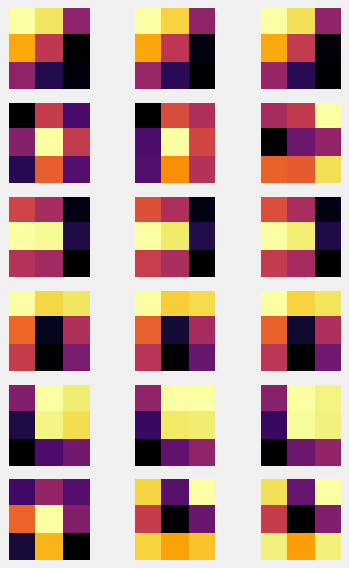

In [228]:
# Visualizing first 6 filters, expanded by RGB
for layer in base_model.layers:
    # check for convolutional layer
    if "conv" not in layer.name:
        continue

# get filter weights
filters, biases = layer.get_weights()
print(layer.name, filters.shape)

# retrieve weights from the second hidden layer
filters, biases = base_model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
print("First 6 filters from 1st conv hidden layer")
plt.figure(figsize=(6, 8))
for i in range(n_filters):
    # slice out 1 specific 3D array to get filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap="inferno")
        ix += 1
# show the figure
plt.tight_layout()

## Plot Feature Extractions

We are also able to visualize how the CNN model extracts features from images passed through the filters. 

The top layers tend to preserve the shape and general characteristics of the image, whereas further down the convolutional blocks, our image is reduced to a few scarce pixels. It is in the lower layers of the network that more specific features are extracted, although it is less interpretable.

In [229]:
# summarize feature map shapes
for i in range(len(base_model.layers)):
    layer = base_model.layers[i]
    # check for convolutional layer
    if "conv" not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [230]:
# redefine model to output right after the first hidden layer
model = Model(inputs=base_model.inputs, outputs=base_model.layers[1].output)

In [231]:
feature_maps = model.predict(img_array)

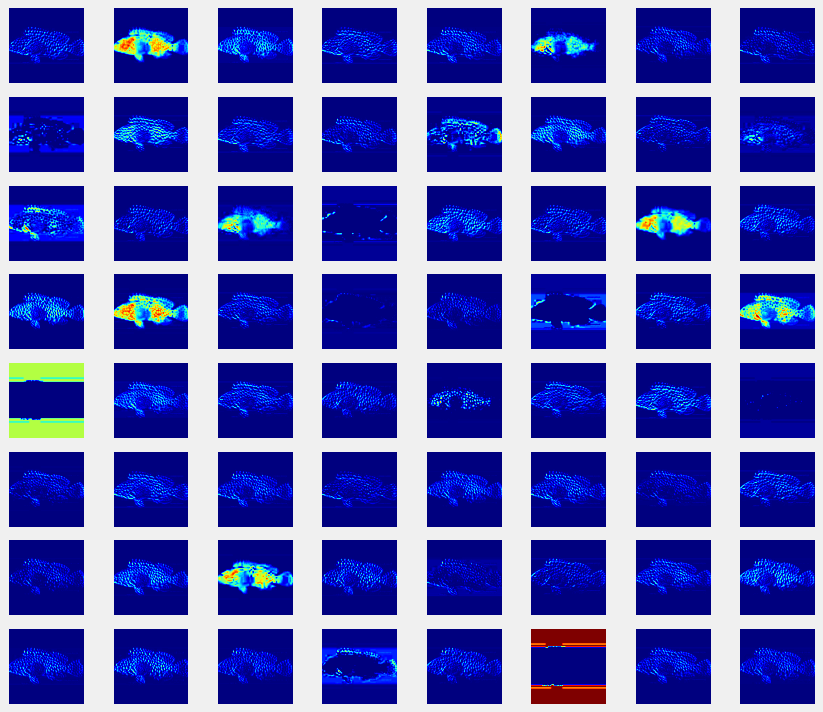

In [232]:
# this is from the 1st convolutional layer: block1_conv1
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1

plt.figure(figsize=(12, 10))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix - 1], cmap="jet")
        ix += 1
# show the figure
plt.tight_layout()

Feature map: Block 1 for VGG16


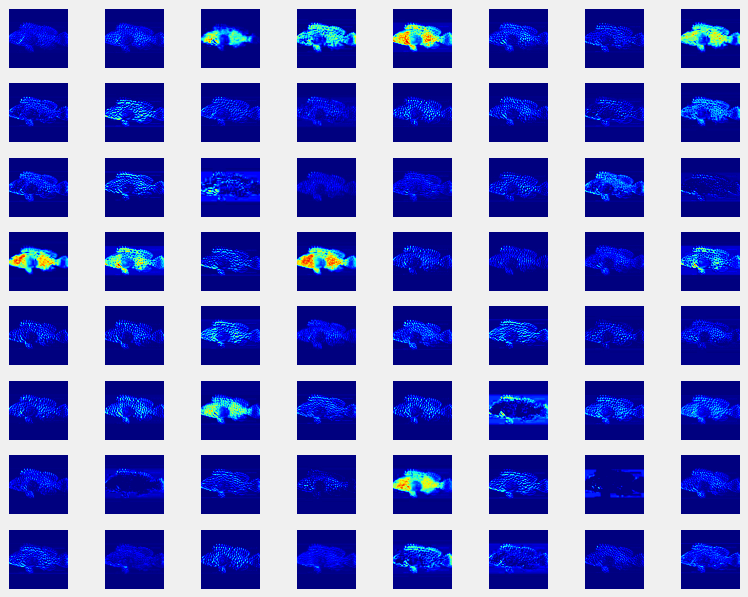

Feature map: Block 2 for VGG16


<Figure size 720x864 with 0 Axes>

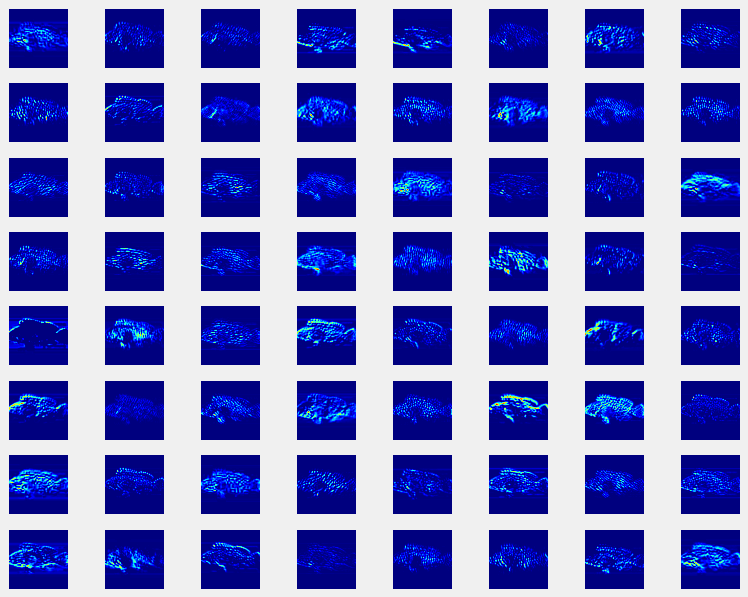

Feature map: Block 3 for VGG16


<Figure size 720x864 with 0 Axes>

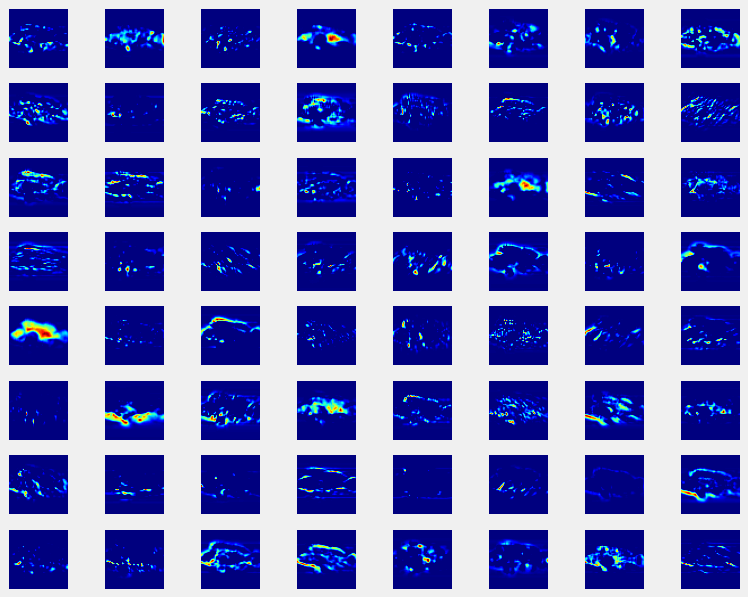

Feature map: Block 4 for VGG16


<Figure size 720x864 with 0 Axes>

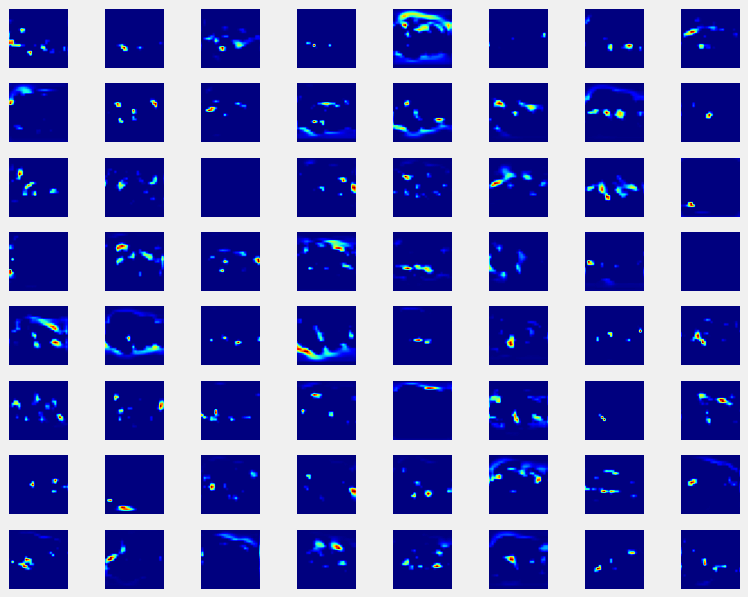

Feature map: Block 5 for VGG16


<Figure size 720x864 with 0 Axes>

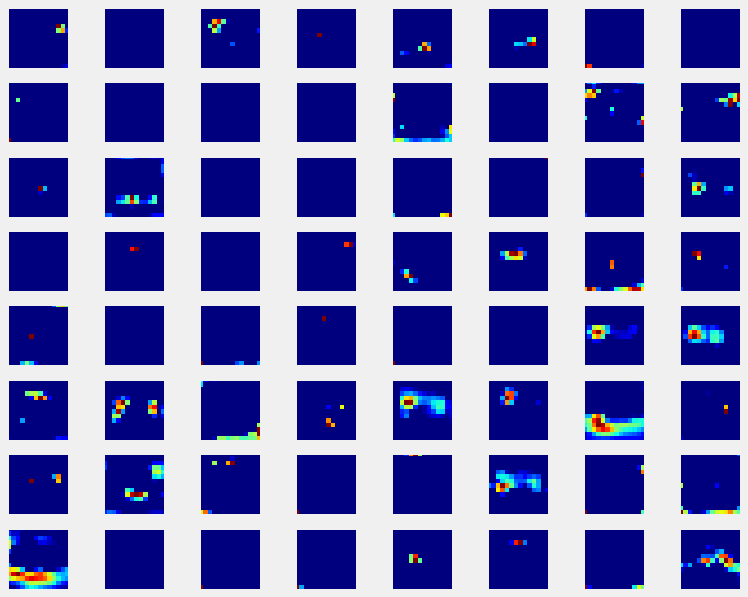

<Figure size 720x864 with 0 Axes>

In [234]:
# visualize how feature extraction is done for each of the 5 blocks
# first 2 blocks - high level features (e.g. shape)
# after which, features extracted are specific to images passed in, and get less interpretable

ixs = [2, 5, 9, 13, 17]

num = 0
for i in ixs:
    num += 1
    print(f"Feature map: Block {num} for VGG16")
    plot_block(i)

## Plot Grad-CAM

Class activation maps (CAM) are used to determine which regions in an image were relevent or used to identify certain classes. 

Earlier during modelling, it was clear that EfficientNetB0 outperformed the other 2 models. Plotting the Grad-CAM gives us an indication of which features were used for prediction. 

As shown, EfficientNet identifies the fish's head as a main feature, which might be the reason for its performance over VGG16 and ResNet50V2 which identifies a random part of the fish's body as a main predictor.

We can also output the Grad-CAM for misclassified images, and identify what 'types / areas' of images are being misclassified. We could then pass in more images of similar types to further train the model and improve scores.

In [235]:
vgg = VGG16()
effnet = EfficientNetB0()
resnet = ResNet50V2()

In [273]:
heatmap_vgg = make_heatmap(vgg, "block5_conv3", img_array)
heatmap_effnet = make_heatmap(effnet, "top_conv", img_array)
heatmap_resnet = make_heatmap(resnet, "conv5_block3_3_conv", img_array)

img_heat_vgg = create_heatmap_overlay(
    os.path.join(base_path, "root/", "honeycomb_grouper", "honeycomb_30.jpeg"),
    heatmap_vgg,
)
img_heat_effnet = create_heatmap_overlay(
    os.path.join(base_path, "root/", "honeycomb_grouper", "honeycomb_30.jpeg"),
    heatmap_effnet,
)
img_heat_resnet = create_heatmap_overlay(
    os.path.join(base_path, "root/", "honeycomb_grouper", "honeycomb_30.jpeg"),
    heatmap_resnet,
)

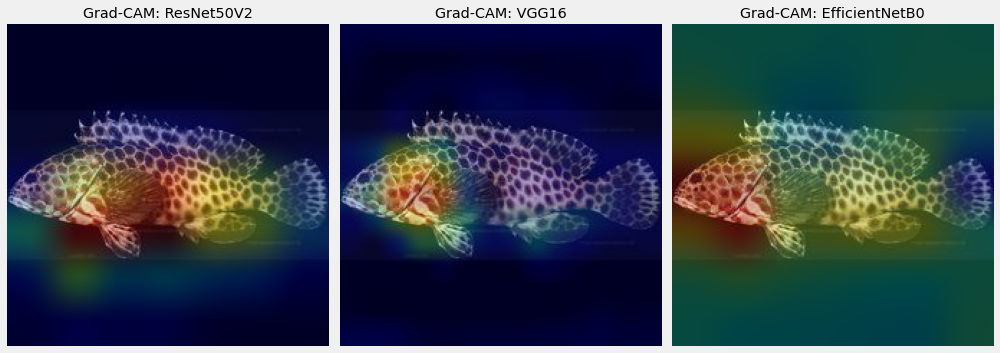

In [280]:
fig = plt.figure(figsize=(14, 6))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(img_heat_resnet)
plt.title("Grad-CAM: ResNet50V2")
plt.axis("off")

fig.add_subplot(rows, columns, 2)
plt.imshow(img_heat_vgg)
plt.axis("off")
plt.title("Grad-CAM: VGG16")

fig.add_subplot(rows, columns, 3)
plt.imshow(img_heat_effnet)
plt.axis("off")
plt.title("Grad-CAM: EfficientNetB0")

plt.tight_layout()

## Plot Misclassified Images

By visualizing the grad-CAM of the 2 commonly misclassified images by all 3 models, we are able to identify ways to improve the accuracy of predictions. 

As far as we can tell, the 2 images do not have a clear distinction between background and foreground (i.e. the target classes are camouflaged). Surprisingly, this happens mostly for the stingray classes. 

To remedy this, we could pass in more images of 'camouflaged' stingrays to train the model, or play around with different contrasts to see if accuracy would improve. 

In [123]:
ensemb_wrong_df

imagepath  ... predicted
58   /content/drive/MyDrive/capstone/datasets/test/...  ...       1.0
84   /content/drive/MyDrive/capstone/datasets/test/...  ...       0.0
129  /content/drive/MyDrive/capstone/datasets/test/...  ...       2.0

[3 rows x 5 columns]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(-0.5, 223.5, 223.5, -0.5)

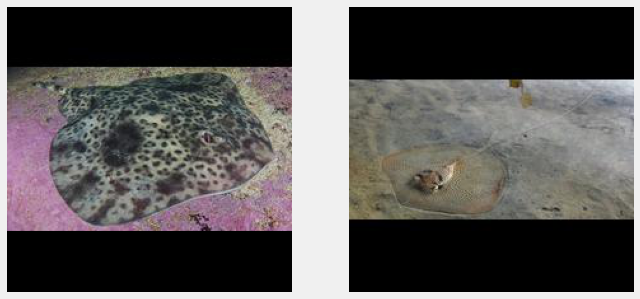

In [141]:
# these are the 2 images misclassified across all models
ensemb_wrong_df = test_df[test_df["category"] != final_pred]

miscl_1 = keras.utils.load_img(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_107.jpeg"),
    target_size=(224, 224),
)


miscl_2 = keras.utils.load_img(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_62.jpeg"),
    target_size=(224, 224),
)

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 1)
plt.imshow(miscl_1)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(miscl_2)
plt.axis("off")

In [262]:
# for first image

miscl_1_array = get_img_array(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_107.jpeg"),
    target_size=(224, 224),
)

heatmap_1_vgg = make_heatmap(vgg, "block5_conv3", miscl_1_array)
heatmap_1_effnet = make_heatmap(effnet, "top_conv", miscl_1_array)
heatmap_1_resnet = make_heatmap(resnet, "conv5_block3_3_conv", miscl_1_array)

miscl_1_vgg = create_heatmap_overlay(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_107.jpeg"),
    heatmap_1_vgg,
)
miscl_1_effnet = create_heatmap_overlay(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_107.jpeg"),
    heatmap_1_effnet,
)
miscl_1_resnet = create_heatmap_overlay(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_107.jpeg"),
    heatmap_1_resnet,
)


# for second image

miscl_2_array = get_img_array(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_62.jpeg"),
    target_size=(224, 224),
)

heatmap_2_vgg = make_heatmap(vgg, "block5_conv3", miscl_2_array)
heatmap_2_effnet = make_heatmap(effnet, "top_conv", miscl_2_array)
heatmap_2_resnet = make_heatmap(resnet, "conv5_block3_3_conv", miscl_2_array)

miscl_2_vgg = create_heatmap_overlay(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_62.jpeg"),
    heatmap_2_vgg,
)
miscl_2_effnet = create_heatmap_overlay(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_62.jpeg"),
    heatmap_2_effnet,
)
miscl_2_resnet = create_heatmap_overlay(
    os.path.join(base_path, "root/", "honeycomb_ray", "honeycombray_62.jpeg"),
    heatmap_2_resnet,
)

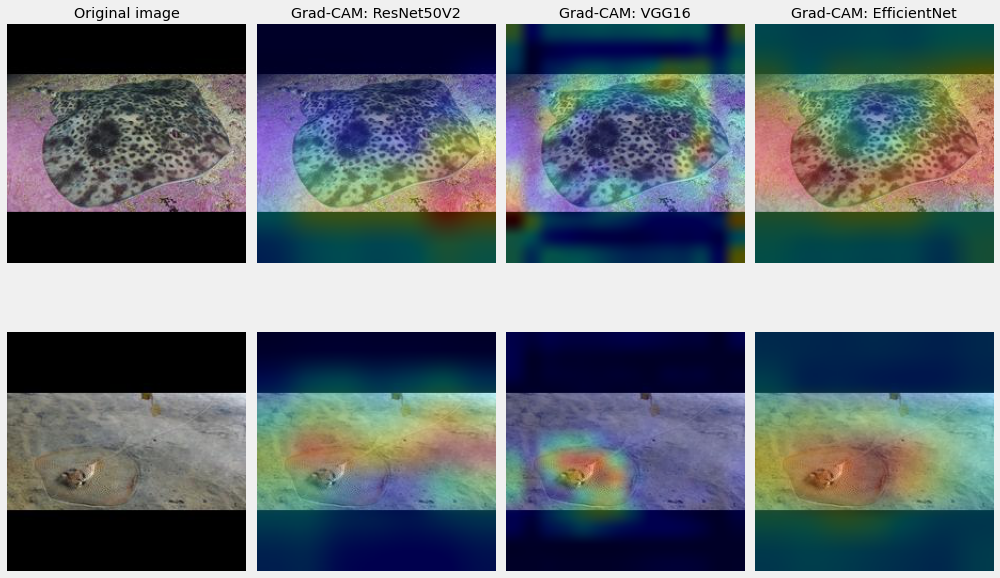

In [271]:
# visualize image with respect to grad-cams

fig = plt.figure(figsize=(14, 10))

rows = 2
columns = 4

fig.add_subplot(rows, columns, 1)
plt.imshow(miscl_1)
plt.title("Original image")
plt.axis("off")

fig.add_subplot(rows, columns, 2)
plt.imshow(miscl_1_resnet)
plt.axis("off")
plt.title("Grad-CAM: ResNet50V2")

fig.add_subplot(rows, columns, 3)
plt.imshow(miscl_1_vgg)
plt.axis("off")
plt.title("Grad-CAM: VGG16")

fig.add_subplot(rows, columns, 4)
plt.imshow(miscl_1_effnet)
plt.axis("off")
plt.title("Grad-CAM: EfficientNet")

fig.add_subplot(rows, columns, 5)
plt.imshow(miscl_2)
plt.axis("off")

fig.add_subplot(rows, columns, 6)
plt.imshow(miscl_2_resnet)
plt.axis("off")

fig.add_subplot(rows, columns, 7)
plt.imshow(miscl_2_vgg)
plt.axis("off")

fig.add_subplot(rows, columns, 8)
plt.imshow(miscl_2_effnet)
plt.axis("off")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.2)


plt.tight_layout()

<a id='link7'></a>


# Conclusion

A total of 1 baseline CNN and 3 pre-trained models were run. Feature extraction and fine tuning was done for all 3 pre-trained models. 

Of the 3 pre-trained models, the EfficientNetB0 performed the best, with an accuracy score of 99.7%. An ensemble neural network was also explored, in hopes that accuracy could improve. 

However, this was not the case, and the ensemble model's accuracy was 99.6%. On further investigation of the CNN black box and utilizing the grad-CAM, we found that there were 2 images commonly misclassfied across all 3 pre-trained models. These images contained subjects that were 'camouflaged' and did not have a 3D profile (flat stingrays). For future work, we could pass in more of such images into the model for training. 

The production ensemble model stands at 99.6% accuracy, which would definitely help in identifying marine life for sustainable fishing. To err on the side of caution, we should always practice catch and release.

## Future Improvements

There are many improvements that can be made in order for this algorithm to be scalable. 
- Adding in more classes to expand what the model can identify 
- To explore colour correction for photos that were taken underwater, as these usually lack the colour red 
- Work on a mobile application that people can use on the go
- Explore how to identify length of catch as this would help differentiate juveniles from adults 

[Home](#link0)